# Tracking simulated cells in 3D
---

Here we are simulating some dividing cells in 3D, tracking them and automatically calculating a lineage tree from the data using BayesianTracker.



In [1]:
%matplotlib inline

# math
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# btrack components
import btrack
from btrack.constants import States
from btrack.render import plot_tracks

[INFO][2019/12/13 12:30:26 PM] btrack (v0.3.1) library imported
[INFO][2019/12/13 12:30:26 PM] Loaded btrack: /home/arl/anaconda3/envs/btrack/lib/python3.7/site-packages/btrack/libs/libtracker.so


In [2]:
# config file 
config_file = '/home/arl/Dropbox/Code/py3/BayesianTracker/models/MDCK_config_wildtype.json'

### Simulate some cells

In [3]:
def new_vector(radius=1., theta=0., phi=0.):
        x = lambda r, t, p: r*np.sin(t)*np.cos(p)
        y = lambda r, t, p: r*np.sin(t)*np.sin(p)
        z = lambda r, t, p: r*np.cos(t)
        vect = np.array([x(radius, theta, phi),
                         y(radius, theta, phi),
                         z(radius, theta, phi)])
        return vect


def new_t_obj(position, frame, label):
    """ get a bayesiantracker object from an observation """
    txyz = np.concatenate([[frame,],position])
    l = np.zeros((6,))
    l[0] = label.value
    return btrack.dataio.ObjectFactory.get(txyz, label=l)


class AgentManager(object):
    def __init__(self,
                 num_agents=100,
                 periodic_boundary=False,
                 noise=0.01,
                 box=1024):

        self.num_agents = num_agents
        self.periodic_boundary = periodic_boundary
        self.noise = noise
        self.box = box

        self.__current_ID = 0

        self.agents = []


    def simulate(self, num_frames):
        """ run the simulation """
        agents = [Agent(ID=self.get_new_ID(),
                  noise=self.noise,
                  periodic_boundary=self.periodic_boundary,
                  position=(0.,0.,0.),
                  frame=0,
                  box=self.box) for a in range(self.num_agents)]

        to_add = []

        # iterate over the frames
        for i in range(num_frames):
            for agent in agents:
                ret = agent.update()
                if ret == States.METAPHASE:
                    to_add = self.mitosis(agent)

            # append any new agents here
            while to_add:
                agents.append(to_add.pop(0))

        self.agents = agents


    def mitosis(self, agent):
        """ perform a mitosis """
        current_pos = agent.position
        r = np.random.randint(10,30)
        theta = np.random.randn()*np.pi
        phi = np.random.randn()*np.pi
        v = new_vector(radius=r, theta=theta, phi=phi)

        frame = agent.frames[-1]

        new_pos = [current_pos-v, current_pos+v]
        new_agents = [Agent(ID=self.get_new_ID(),
                            noise=self.noise,
                            periodic_boundary=self.periodic_boundary,
                            frame=frame+1,
                            position=p.tolist(),
                            box=self.box) for p in new_pos]

        print("Mitosis {}->{},{}".format(agent.ID, new_agents[0].ID, new_agents[1].ID,))

        return new_agents


    def get_new_ID(self):
        """ get a new ID """
        self.__current_ID+=1
        return self.__current_ID


    def get_data(self):
        """ get all of the data """
        data = []
        for agent in self.agents:
            data += agent.get_objects()
        return data

    
class Agent(object):
    """ Agent

    An Agent class that can be used to simulate a moving object in a field of
    view.

    Args:
        noise: normally distributed noise in speed and angle(s)
        periodic_boundary: a bool which causes agents to wrap around edges of
            bounding box
        box: size of initialisation/bounding box
        speed: agent speed

    """
    def __init__(self,
                 ID=0,
                 noise=.1,
                 periodic_boundary=False,
                 position=[],
                 frame=0,
                 box=1024):

        self.ID = ID

        self.box = box
        self.periodic_boundary = periodic_boundary

        if not position:
            self.position = np.random.randint(0,high=self.box, size=(3,))
        else:
            self.position = np.array(position)

        self.theta = np.random.randn(2,)*np.pi # az and elev
        self.speed = 1.
        self.noise = noise

        self.frame = frame

        # position, label=3 (anaphase for starting track)
        self.trajectory = [self.position]
        self.labels = [States.ANAPHASE]
        self.frames = [frame]

        self.predicted = None

        # sampling noise
        self.sample_noise = 0.1
        self.sample_iter = 0

        # active track?
        self.active = True

        # division?
        self.division_time = 300


    @property
    def division_clock(self):
        return self.frames[-1]-self.frames[0]

    def update(self):
        if not self.active:
            return None

        t = self.theta + np.random.randn(2,)*self.noise
        s = max(self.speed + np.random.randn()*self.noise, 0.)
        v = new_vector(radius=s, theta=t[0], phi=t[1])
        v[-1] = 0.
        self.position = self.position + v

        if self.periodic_boundary:
            self.position = np.mod(self.position, self.box)

        if self.divide():
            label = States.METAPHASE # metaphase
        else:
            label = States.INTERPHASE # interphase

        self.frames.append(self.frames[-1]+1)
        self.trajectory.append(self.position)
        self.labels.append(label)
        self.theta = t

        return label



    def divide(self):
        if self.division_clock >= self.division_time+np.random.randn()*10:
            self.active = False
            return True
        return False


    def get_objects(self):
        objects = []
        for i in range(len(self)):
            o = new_t_obj(self.trajectory[i],
                          self.frames[i],
                          self.labels[i])
            objects.append(o)
        return objects


    def __len__(self): return len(self.trajectory)


    @property
    def x(self): return self.coords(0)
    @property
    def y(self): return self.coords(1)
    @property
    def z(self): return self.coords(2)

    def coords(self, axis=0):
        return [self.trajectory[i][axis] for i in range(len(self.trajectory))]

In [4]:
# instantiate agents
# num_chaff = 3000
num_frames = 1500

manager = AgentManager(num_agents=1, noise=0.1, periodic_boundary=False)
manager.simulate(num_frames)

Mitosis 1->2,3
Mitosis 3->4,5
Mitosis 2->6,7
Mitosis 4->8,9
Mitosis 5->10,11
Mitosis 7->12,13
Mitosis 6->14,15
Mitosis 8->16,17
Mitosis 9->18,19
Mitosis 11->20,21
Mitosis 10->22,23
Mitosis 13->24,25
Mitosis 12->26,27
Mitosis 14->28,29
Mitosis 15->30,31
Mitosis 17->32,33
Mitosis 16->34,35
Mitosis 23->36,37
Mitosis 24->38,39
Mitosis 22->40,41
Mitosis 20->42,43
Mitosis 25->44,45
Mitosis 19->46,47
Mitosis 18->48,49
Mitosis 21->50,51
Mitosis 26->52,53
Mitosis 28->54,55
Mitosis 29->56,57
Mitosis 27->58,59
Mitosis 30->60,61
Mitosis 31->62,63


### Start a BayesianTracker session

Get the simulated agents (dividing cells) and dropout some of the observations to challenge the tracker.

In [5]:
data = manager.get_data()

In [6]:
# shuffle the data (BT sorts it anyway) and dropout a fraction to simulate segmentation misses
dropout_rate = 0.01
import random
random.shuffle(data)
dropout = int(float(len(data))*dropout_rate)
for i in range(dropout):
    data.pop(0)

In [7]:
# count the number of metaphase (label=2) observations
dl = [d.label for d in data]
dl.count(2)

31

In [8]:
# start a session
with btrack.BayesianTracker() as trk:

    trk.append(data)

    trk.configure_from_file(config_file)
    trk.return_kalman = True

    
#     trk.volume = ((-2048,2048),(-2048,2048),(-2048,2048))
    trk.volume = ((-512, 512), (-512, 512), (-512, 512))
    trk.track_interactive(step_size=500)
    
    # get the tracks
    tracks = trk.tracks

    
    # get the imaging volume (xyzt)
    volume = trk.volume

    # generate some hypotheses and optimise
    hypotheses = trk.hypotheses()
    trk.optimise()
    
    # get the optimized tracks
    tracks2 = trk.tracks



[INFO][2019/12/13 12:30:26 PM] Starting BayesianTracker session
[INFO][2019/12/13 12:30:26 PM] Loading configuration file: /home/arl/Dropbox/Code/py3/BayesianTracker/models/MDCK_config_wildtype.json
[INFO][2019/12/13 12:30:26 PM] Loading motion model: b'MDCK_motion'
[INFO][2019/12/13 12:30:26 PM] Set volume to ((-512, 512), (-512, 512), (-512, 512))
[INFO][2019/12/13 12:30:26 PM] Starting tracking... 
[INFO][2019/12/13 12:30:26 PM] Tracking objects in frames 0 to 499 (of 1506)...
[INFO][2019/12/13 12:30:26 PM]  - Timing (Bayesian updates: 0.00ms, Linking: 0.00ms)
[INFO][2019/12/13 12:30:26 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2019/12/13 12:30:26 PM]  - Stats (Active: 2, Lost: 10, Conflicts resolved: 2)
[INFO][2019/12/13 12:30:26 PM] Tracking objects in frames 500 to 999 (of 1506)...
[INFO][2019/12/13 12:30:26 PM]  - Timing (Bayesian updates: 0.01ms, Linking: 0.02ms)
[INFO][2019/12/13 12:30:26 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2019/12/13 12

In [9]:
# test that some optimization has occurred!
tracks == tracks2

False

In [10]:
# print(volume)
# for hyp in hypotheses:
#     print(hyp.type)

In [11]:
# count how many divisions we see
mitotic_tracks = [trk for trk in tracks2 if trk.fate==4]
for t in mitotic_tracks: print(t.ID,'->', t.children)

### Plot the trajectories and the original data
---

Plot the output of the tracking...

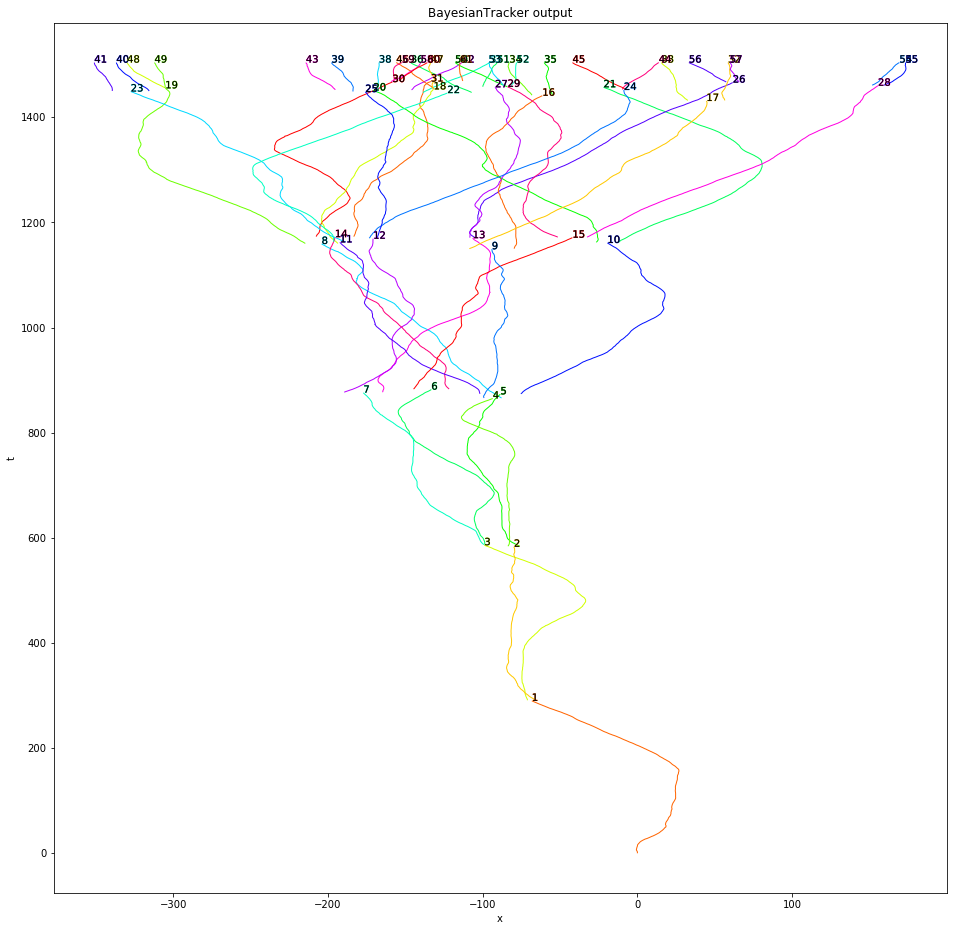

In [12]:
plot_tracks(tracks, order='xt', box=volume, cmap=plt.get_cmap('hsv'), labels=True)

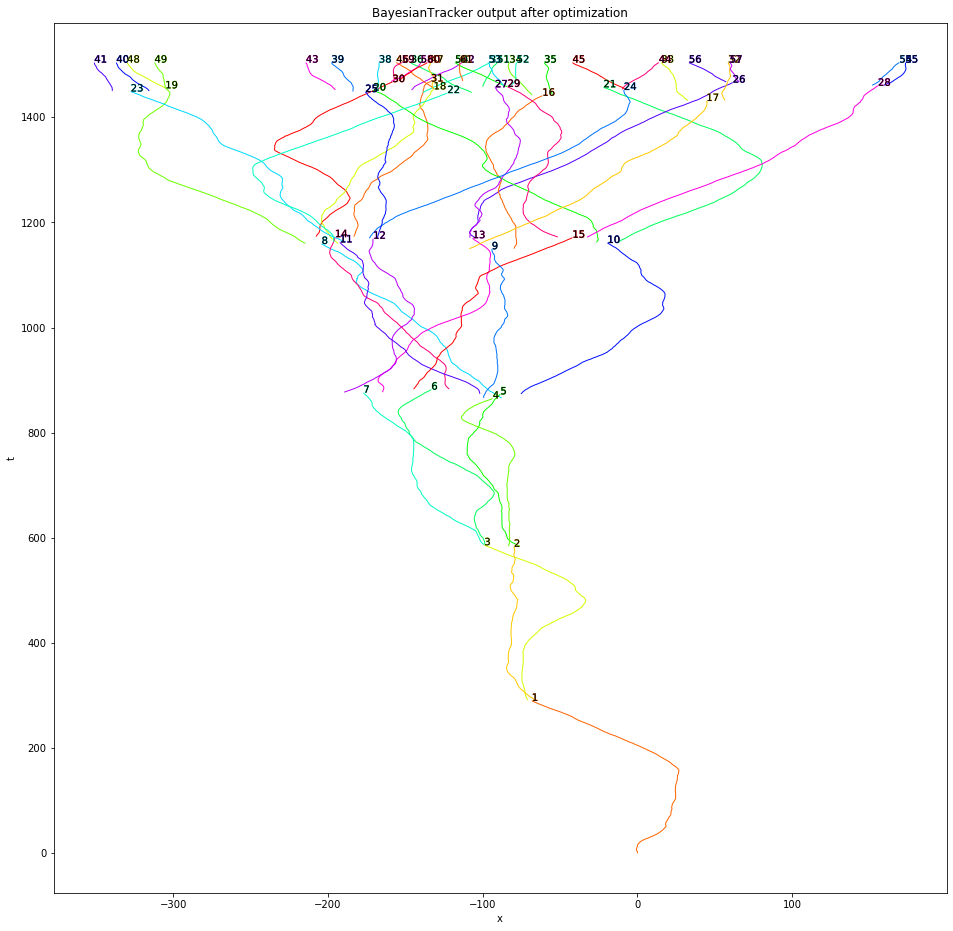

In [13]:
plot_tracks(tracks2, order='xt', box=volume, cmap=plt.get_cmap('hsv'), labels=True, title='BayesianTracker output after optimization')

In [14]:
from btrack.dataio import export_LBEP

In [15]:
tracks2.sort(key=lambda t: t.ID)
export_LBEP("/home/arl/Desktop/test_LBEP.txt", None, tracks2)

[INFO][2019/12/13 12:30:27 PM] Writing LBEP file: /home/arl/Desktop/test_LBEP.txt...


### visualize this in napari

In [16]:
import napari

In [17]:
cmap=plt.get_cmap('hsv')
colors_rgb = [cmap(int(i)) for i in np.linspace(0,255,16)]

In [18]:
napari_tracks = [np.stack([t.x, t.y, t.t], axis=1) for t in tracks2]
napari_track_colors = [colors_rgb[t.ID % 16] for t in tracks2]

In [19]:
print(napari_tracks[0].shape)

(291, 3)


In [20]:
# start napari
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    
    layer = viewer.add_shapes(napari_tracks, shape_type='path', edge_width=5,
                              edge_color=napari_track_colors, name='Lineage Tree')